## Introduction
This notebook is designed for the user to setup NHM-Assist and a provided NHM subbasin model in a project workspace.  If you have not been provided a NHM subbasin model, default paths are set to an example model that can be downloaded from the USGS OSN storage pod following these steps.
1. Open up a miniforge prompt.
2. cd to the **NHM-Assist** folder
3. type `python pull_domain.py --name=willamette_river`

## National Hydrologic Model subabsin models
A sub-basin models for any domain within the NHM are extracted using an automated workflow that generates a complete set of PRMS input files that contain the data and parameters required for a NHM-PRMS model [Regan and others, 2018](https://pubs.usgs.gov/publication/tm6B9). This tool is written in the [Python language](https://www.python.org) and is designed to be run from the command line on [USGS high-performance computing resources](https://www.usgs.gov/advanced-research-computing). At this time, users do not need to download this software and instead can request a model subset following these steps:

1. Go to the web page [https://www.sciencebase.gov/catalog/item/5e29b87fe4b0a79317cf7df5](https://www.sciencebase.gov/catalog/item/5e29b87fe4b0a79317cf7df5)
2. Click the child item titled, [“GIS Features of the Geospatial Fabric for the National Hydrologic Model, version 1.1.”](https://www.sciencebase.gov/catalog/item/5e29d1a0e4b0a79317cf7f63)
3. Download attached files "GFv1.1.gdb.zip" and compare NHM segments to your area-of-interest.
4. Send an emial to pnorton@usgs.gov that includes the following:
   * Name, Email address, Organization, and optionally, Phone;
   * Using GFv1.1.gdb, include one or more national model segments (nhm_seg) associated with watershed outlet(s) points in your area-of-interest.
   * Include a short descriptive summary of your modeling application.
     

In [ ]:
import warnings
from urllib import request
from urllib.request import urlopen
from urllib.error import HTTPError

import re
from io import StringIO
import os

os.environ["USE_PYGEOS"] = "0"

import geopandas as gpd
import xarray as xr
import pandas as pd
import pathlib as pl
import numpy as np
import pyogrio

import netCDF4

import ipyleaflet

import branca
import branca.colormap as cm

import folium
from folium import Circle, Marker
from folium import plugins
from folium.features import DivIcon
from folium.plugins import MarkerCluster
from ipywidgets import widgets

from ipyleaflet import Map, GeoJSON

# PyPRMS needs
from pyPRMS import Dimensions
from pyPRMS.metadata.metadata import MetaData
from pyPRMS import ControlFile
from pyPRMS import Parameters
from pyPRMS import ParameterFile
from pyPRMS.prms_helpers import get_file_iter, cond_check
from pyPRMS.constants import (
    DIMENSIONS_HDR,
    PARAMETERS_HDR,
    VAR_DELIM,
    PTYPE_TO_PRMS_TYPE,
    PTYPE_TO_DTYPE,
)
from pyPRMS.Exceptions_custom import ParameterExistsError, ParameterNotValidError
import networkx as nx
from collections.abc import KeysView

from rich.console import Console
from rich.progress import track
from rich.progress import Progress
from rich import pretty

pretty.install()
con = Console()

warnings.filterwarnings("ignore")

#### Adds:
import matplotlib as mplib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
from datetime import datetime

import ipyleaflet
from ipyleaflet import Map, GeoJSON

from folium import Choropleth
from folium.plugins import BeautifyIcon

import branca
import branca.colormap as cm

import plotly.graph_objects as go
import plotly
import plotly.subplots
import plotly.express as px

import dataretrieval.nwis as nwis

import efc

import jupyter_black

jupyter_black.load()

## Workspace Setup
The NHM-Assist repository is designed to be placed in a project folder. Two subfolders in the the NHM-Assist repository have critical supporting documents.

1. The **data_dependencis** folder with needed supporting files not included in the NHM v1.1 data release [Markstrom and others, 2024](https://www.sciencebase.gov/catalog/item/626c0d67d34e76103cd2ce4a)

2. The **data_domain** folder contains the provided NHM subbasin model.
    The provided NHM subbasin model folder should contain:
    - **control.default.bandit**
    - **myparam.param**
    - **sf_data.nc**
    - **cbh.nc**
    - **GIS** folder containing
        - **model_nhru.shp**
        - **model_nsegment.shp**
        - **model_npoigages.shp**
        - and/or **model_layers.gpkg**
          
    NHM-Assist will create additional files and folders in NHM subbasin model folder. These include
    - **default_gages.csv**
    - **NWISgages.csv**
    - **tmin.nc**
    - **tmax.nc**
    - **prcp.nc**
    - **model_output** folder
    - **notebook_output_files** folder containing:
        - **Folium_maps** folder
        - **GeoDataFrames** folder
        - **nc_files** folder
        - **shapefiles** folder
    **Note:** If subfolders do no exist, they will be created when needed.

   



## User must enter/review settings here:

#### Enter the NHMx folder name here:

In [ ]:
model_dir = pl.Path("domain_data/willamette_river")

In [ ]:
# Establish paths
out_dir = model_dir / "output"
#root_dir = pl.Path("../").resolve()
notebook_dir = pl.Path("./").resolve()
NHM_dir = f"{notebook_dir}/data_dependencies/NHM_v1_1"

#### Enter the format fo the GIS data here:

In [ ]:
GIS_format = ".gpkg"  #'.gpkg'# '.shp'# '.gpkg'

#### Enter the selected parameter file name here:
##### This can change if you want to run the byHRU, byHW, byHWobs parameter files.

In [ ]:
param_file = (
    "myparam.param"  # Can replace with parameter filenames from other calibrations.
)
control_file_name = "control.default.bandit"

#### Enter the model output file name here:
##### The model output file name is set in Notebook "2b Run NHMx_pyWatershed.ipynb" 

In [ ]:
NHM_output_name = "model_custom_output.nc"

#### Enter model domain flag here
##### 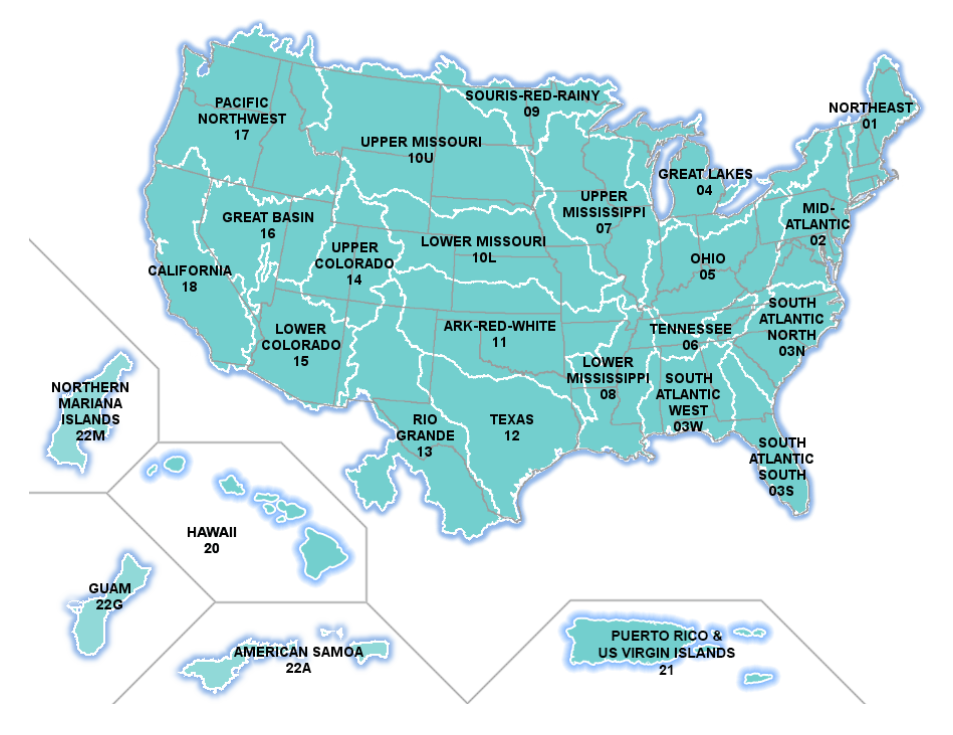
##### https://www.epa.gov/waterdata/get-nhdplus-national-hydrography-dataset-plus-data
##### Please list the Region(s) that intersect the NHMx domain.

In [ ]:
model_domain_regions = ["17"]  # you can list one, two, or many here

# This is part of a custom setup for OWRD projects
if (
    ("16" in model_domain_regions)
    or ("17" in model_domain_regions)
    or ("18" in model_domain_regions)
):
    owrd_domain = "yes"
    con.print(f"The WA-OR domain option is set to {owrd_domain}.")
else:
    owrd_domain = "no"

In [ ]:
### Helper Functions
def subset_stream_network(dag_ds, uscutoff_seg, dsmost_seg):  # (from Bandit)
    """Extract subset of stream network

    :param dag_ds: Directed, acyclic graph of downstream stream network
    :param uscutoff_seg: List of upstream cutoff segments
    :param dsmost_seg: List of outlet segments to start extraction from

    :returns: Stream network of extracted segments
    """

    # taken from Bandit bandit_helpers.py

    # Create the upstream graph
    dag_us = dag_ds.reverse()

    # Trim the u/s graph to remove segments above the u/s cutoff segments
    try:
        for xx in uscutoff_seg:
            try:
                dag_us.remove_nodes_from(nx.dfs_predecessors(dag_us, xx))

                # Also remove the cutoff segment itself
                dag_us.remove_node(xx)
            except KeyError:
                print(f"WARNING: nhm_segment {xx} does not exist in stream network")
    except TypeError:
        print(
            "\nSelected cutoffs should at least be an empty list instead of NoneType."
        )

    # =======================================
    # Given a d/s segment (dsmost_seg) create a subset of u/s segments

    # Get all unique segments u/s of the starting segment
    uniq_seg_us: Set[int] = set()
    if dsmost_seg:
        for xx in dsmost_seg:
            try:
                pred = nx.dfs_predecessors(dag_us, xx)
                uniq_seg_us = uniq_seg_us.union(
                    set(pred.keys()).union(set(pred.values()))
                )
            except KeyError:
                print(f"KeyError: Segment {xx} does not exist in stream network")

        # Get a subgraph in the dag_ds graph and return the edges
        dag_ds_subset = dag_ds.subgraph(uniq_seg_us).copy()

        node_outlets = [ee[0] for ee in dag_ds_subset.edges()]
        true_outlets = set(dsmost_seg).difference(set(node_outlets))

        # Add the downstream segments that exit the subgraph
        for xx in true_outlets:
            nhm_outlet = list(dag_ds.neighbors(xx))[0]
            dag_ds_subset.add_node(
                nhm_outlet, style="filled", fontcolor="white", fillcolor="grey"
            )
            dag_ds_subset.add_edge(xx, nhm_outlet)
            dag_ds_subset.nodes[xx]["style"] = "filled"
            dag_ds_subset.nodes[xx]["fontcolor"] = "white"
            dag_ds_subset.nodes[xx]["fillcolor"] = "blue"
    else:
        # No outlets specified so pull the full model
        dag_ds_subset = dag_ds

    return dag_ds_subset


def hrus_by_seg(pdb, segs):  # (custom code)
    # segs: global segment IDs

    if isinstance(segs, int):
        segs = [segs]
    elif isinstance(segs, KeysView):
        segs = list(segs)

    seg_hrus = {}
    seg_to_hru = pdb.seg_to_hru

    # Generate stream network for the model
    dag_streamnet = pdb.stream_network()

    for cseg in segs:
        # Lookup segment for the current POI
        dsmost_seg = [cseg]

        # Get subset of stream network for given POI
        dag_ds_subset = subset_stream_network(dag_streamnet, set(), dsmost_seg)

        # Create list of segments in the subset
        toseg_idx = list(set(xx[0] for xx in dag_ds_subset.edges))

        # Build list of HRUs that contribute to the POI
        final_hru_list = []

        for xx in toseg_idx:
            try:
                for yy in seg_to_hru[xx]:
                    final_hru_list.append(yy)
            except KeyError:
                # print(f'Segment {xx} has no HRUs connected to it') # comment this out and add pass to not print the KeyError
                pass
        final_hru_list.sort()

        seg_hrus[cseg] = final_hru_list

    return seg_hrus


def hrus_by_poi(pdb, poi):  # (custom code)
    if isinstance(poi, str):
        poi = [poi]
    elif isinstance(poi, KeysView):
        poi = list(poi)

    poi_hrus = {}
    nhm_seg = pdb.get("nhm_seg").data
    pois_dict = pdb.poi_to_seg
    seg_to_hru = pdb.seg_to_hru

    # Generate stream network for the model
    dag_streamnet = pdb.stream_network()

    for cpoi in poi:
        # Lookup global segment id for the current POI
        dsmost_seg = [nhm_seg[pois_dict[cpoi] - 1]]

        # Get subset of stream network for given POI
        dag_ds_subset = subset_stream_network(dag_streamnet, set(), dsmost_seg)

        # Create list of segments in the subset
        toseg_idx = list(set(xx[0] for xx in dag_ds_subset.edges))

        # Build list of HRUs that contribute to the POI
        final_hru_list = []

        for xx in toseg_idx:
            try:
                for yy in seg_to_hru[xx]:
                    final_hru_list.append(yy)
            except KeyError:
                # Not all segments have HRUs connected to them
                # print(f'{cpoi}: Segment {xx} has no HRUs connected to it')
                pass
        final_hru_list.sort()
        poi_hrus[cpoi] = final_hru_list

    return poi_hrus

In [ ]:
if not pl.Path.exists(
    out_dir
):  # Checks to see if the folder already exists and writes folder if absent
    out_dir_txt = f"          NHMx [bold blue]output folder[/bold blue] --created."
    pl.Path(out_dir).mkdir(
        parents=True, exist_ok=True
    )  # makes the new folder if not there already
else:
    out_dir_txt = f"          NHMx [bold blue]output folder[/bold blue] --exists."


param_filename = f"{model_dir}/{param_file}"
custom_output_file = out_dir / NHM_output_name

prms_meta = MetaData(version=5, verbose=False).metadata
pdb = ParameterFile(param_filename, metadata=prms_meta, verbose=False)

root_dir_txt = f"NHM-Assist is located in [bold black]Project Folder[/bold black] (root directory) [bold black]{root_dir}[/bold black]"
model_dir_txt = f"     The Selected [bold black]NHMx model[/bold black] is [bold black]{model_dir}[/bold black]"
param_file_txt = (
    f"          model parameter file : [bold black]{param_file}[/bold black]"
)

# Other file path names are hardcoded here for NHM-Assist
nwis_gages_file = model_dir / "NWISgages.csv"
gages_file = model_dir / "gages.csv"  # Provided from OWRD
default_gages_file = model_dir / "default_gages.csv"  # Provided from OWRD
output_netcdf_filename = model_dir / "notebook_output_files" / "nc_files" / "sf_efc.nc"

# Create/verify Jupyter notebooks output folder and subfolders in the model directory.
notebook_output_dir = pl.Path(
    model_dir / "notebook_output_files"
).resolve()  # sets a path variable for the new folder
if not pl.Path.exists(
    notebook_output_dir
):  # Checks to see if the folder already exists and writes folder if absent
    nb_out_dir_txt = (
        f"          [bold black]notebook_output_files folder[/bold black] --created."
    )
    pl.Path(notebook_output_dir).mkdir(
        parents=True, exist_ok=True
    )  # makes the new folder if not there already
else:
    nb_out_dir_txt = (
        f"          [bold black]notebook_output_files folder[/bold black] --exists."
    )

shapefile_dir = pl.Path(
    notebook_output_dir / "shapefiles"
).resolve()  # Directory where shapefiles from Book 1 were written
if not pl.Path.exists(
    shapefile_dir
):  # Checks to see if the folder already exists and writes folder if absent
    shapefile_dir_txt = (
        f"               [bold black]shapefiles folder[/bold black] --created."
    )
    pl.Path(shapefile_dir).mkdir(
        parents=True, exist_ok=True
    )  # makes the new folder if not there already
else:
    shapefile_dir_txt = (
        f"               [bold black]shapefiles folder[/bold black] --exists."
    )

GeoDataFrames_dir = pl.Path(notebook_output_dir / "GeoDataFrames").resolve()
if not pl.Path.exists(
    GeoDataFrames_dir
):  # Checks to see if the folder already exists and writes folder if absent
    GeoDataFrames_dir_txt = (
        f"               [bold black]GeoDataFrames folder[/bold black] --created."
    )
    pl.Path(GeoDataFrames_dir).mkdir(
        parents=True, exist_ok=True
    )  # makes the new folder if not there already
else:
    GeoDataFrames_dir_txt = (
        f"               [bold black]GeoDataFrames folder[/bold black] --exists."
    )

Folium_maps_dir = pl.Path(notebook_output_dir / "Folium_maps").resolve()
if not pl.Path.exists(
    Folium_maps_dir
):  # Checks to see if the folder already exists and writes folder if absent
    Folium_maps_dir_txt = (
        f"               [bold black]Folium_maps folder[/bold black] --created."
    )
    pl.Path(Folium_maps_dir).mkdir(
        parents=True, exist_ok=True
    )  # makes the new folder if not there already
else:
    Folium_maps_dir_txt = (
        f"               [bold black]Folium_maps folder[/bold black] --exists."
    )

##Check to see if the output subdirectory was already made, and if not will make it.
nc_files_dir = pl.Path(notebook_output_dir / "nc_files").resolve()
if not (notebook_output_dir / "nc_files").exists():
    nc_files_dir_txt = (
        f"               [bold black]nc_files[/bold black] folder --created."
    )
    (notebook_output_dir / "nc_files").mkdir(parents=True)
else:
    nc_files_dir_txt = (
        f"               [bold black]nc_files[/bold black] folder --exists."
    )

con.print(
    root_dir_txt,
    "\n",
    model_dir_txt,
    "\n",
    out_dir_txt,
    "\n",
    param_file_txt,
    "\n",
    nb_out_dir_txt,
    "\n",
    shapefile_dir_txt,
    "\n",
    GeoDataFrames_dir_txt,
    "\n",
    Folium_maps_dir_txt,
    "\n",
    nc_files_dir_txt,
    "\n",
)